In [3]:
import rioxarray as rxr
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np

In [14]:
import xml.etree.ElementTree as ET

xml_fp = "cdnf43p_v2r1/cdnf43p.xml"
tree = ET.parse(xml_fp)
root = tree.getroot()

# Print a few key metadata tags
for elem in root.iter():
    if "Projection" in elem.tag or "Datum" in elem.tag or "Resolution" in elem.tag:
        print(elem.tag, ":", elem.text)


Spheroid_Datum :  GCS, WGS-1984
Resolution : 1 arc sec
Spatial_Resolution : 1arc sec
Spatial_Resolution_Unit : m


In [8]:
dem_fp = r"cdnf43p_v2r1/cdnf43p.tif"
import os
print("File exists?", os.path.exists(dem_fp))


File exists? True


In [9]:
import rioxarray as rxr
dem = rxr.open_rasterio(dem_fp, masked=True).squeeze()
dem


<xarray.DataArray (y: 3600, x: 3600)> Size: 52MB
[12960000 values with dtype=float32]
Coordinates:
  * y            (y) float64 29kB 22.0 22.0 22.0 22.0 ... 21.0 21.0 21.0 21.0
  * x            (x) float64 29kB 75.0 75.0 75.0 75.0 ... 76.0 76.0 76.0 76.0
    band         int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_SOFTWARE:        ERDAS IMAGINE
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0

In [15]:
print("CRS:", dem.rio.crs)
print("Resolution (pixel size):", dem.rio.resolution())
print("Extent (bounds):", dem.rio.bounds())
print("Shape:", dem.shape)
print("Data Type:", dem.dtype)


CRS: EPSG:4326
Resolution (pixel size): (0.0002777777777777778, -0.0002777777777777778)
Extent (bounds): (74.99986111111112, 21.00013888888889, 75.9998611111111, 22.000138888888888)
Shape: (3600, 3600)
Data Type: float32


In [11]:
import numpy as np
arr = dem.values
flat = arr[~np.isnan(arr)]  # remove NaN pixels

print(" Basic DEM Statistics:")
print(f"Minimum Elevation: {flat.min():.2f} m")
print(f"Maximum Elevation: {flat.max():.2f} m")
print(f"Mean Elevation:    {flat.mean():.2f} m")
print(f"Median Elevation:  {np.median(flat):.2f} m")
print(f"Total Valid Pixels: {flat.size}")


 Basic DEM Statistics:
Minimum Elevation: 67.00 m
Maximum Elevation: 1013.00 m
Mean Elevation:    285.66 m
Median Elevation:  231.00 m
Total Valid Pixels: 12960000


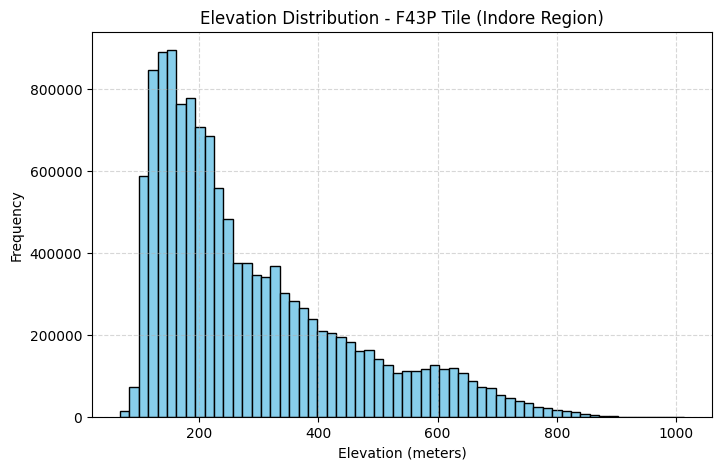

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(flat, bins=60, color="skyblue", edgecolor="black")
plt.title("Elevation Distribution - F43P Tile (Indore Region)")
plt.xlabel("Elevation (meters)")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


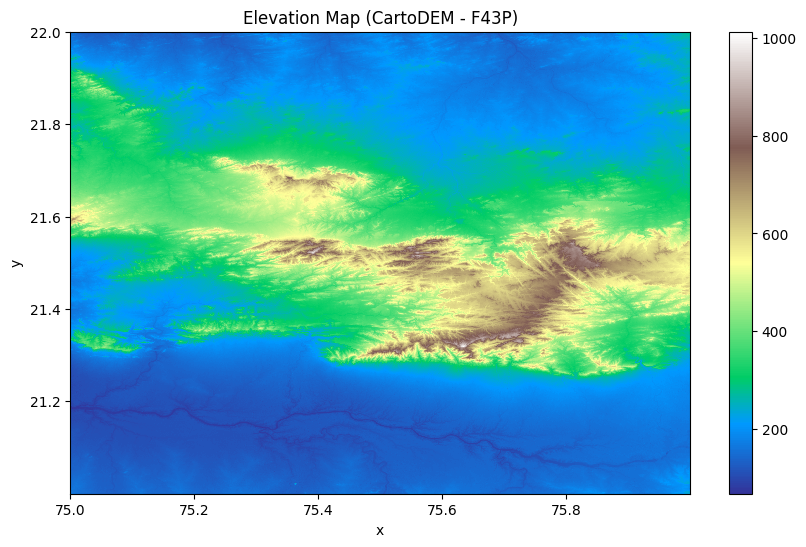

In [16]:
plt.figure(figsize=(10,6))
dem.plot(cmap="terrain")
plt.title("Elevation Map (CartoDEM - F43P)")
plt.show()


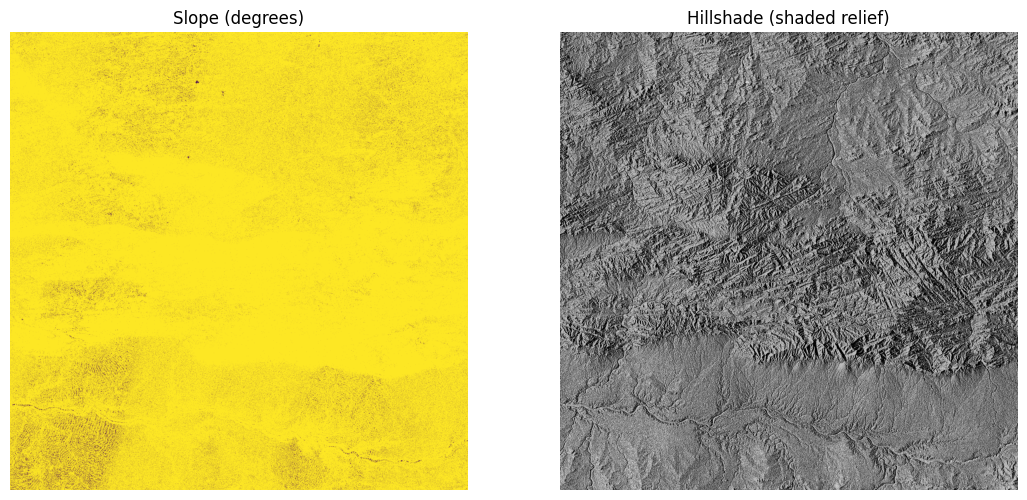

In [13]:
from matplotlib.colors import LightSource

# Convert DEM to numpy array
elev = dem.values.astype(float)

# Get pixel size (from transform)
transform = dem.rio.transform()
px = transform[0]      # pixel width
py = -transform[4]     # pixel height

# Compute gradient (change in elevation)
dzdx = (np.roll(elev, -1, axis=1) - np.roll(elev, 1, axis=1)) / (2 * px)
dzdy = (np.roll(elev, -1, axis=0) - np.roll(elev, 1, axis=0)) / (2 * py)

# Compute slope and hillshade
slope_rad = np.arctan(np.sqrt(dzdx**2 + dzdy**2))
slope_deg = np.degrees(slope_rad)

# Hillshade using matplotlib’s LightSource
ls = LightSource(azdeg=315, altdeg=45)
hillshade = ls.hillshade(elev, vert_exag=1, dx=px)

# Plot slope and hillshade side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,6))
ax1.imshow(slope_deg, cmap="viridis")
ax1.set_title("Slope (degrees)")
ax1.axis("off")

ax2.imshow(hillshade, cmap="gray")
ax2.set_title("Hillshade (shaded relief)")
ax2.axis("off")

plt.show()


In [17]:

nodata = dem.rio.nodata  # the value used to mark missing pixels in DEM metadata
print("Declared NoData value in file:", nodata)

# Convert the DEM to numpy array for analysis
arr = dem.values
missing_pixels = np.isnan(arr).sum()

print("Missing (NaN) pixels:", missing_pixels)
print("Total pixels:", arr.size)
print(f"Percentage missing: {missing_pixels / arr.size * 100:.4f}%")


Declared NoData value in file: None
Missing (NaN) pixels: 0
Total pixels: 12960000
Percentage missing: 0.0000%


---

# Summary and Interpretation — CartoDEM (F43P Tile, Indore Region)

###  Dataset Overview
- **Dataset Name:** CartoDEM v2 R1  
- **Tile ID:** F43P (covering Indore, Madhya Pradesh)  
- **Source:** Bhuvan – Indian Geo-Platform (NRSC/ISRO)  
- **Format:** GeoTIFF (`cdnf43p.tif`) with metadata (`cdnf43p.xml`)  
- **Spatial Resolution:** 30 meters  
- **Coordinate System:** WGS84 (EPSG:4326)  
- **Vertical Units:** Elevation in meters above mean sea level  
- **Data Period:** 2005–2014  

---

###  Statistical Summary
| Metric                    |           Value |
|:--|--:|
| **Minimum Elevation**     |         67.00 m |
| **Maximum Elevation**     |       1013.00 m |
| **Mean Elevation**        |        285.66 m |
| **Median Elevation**      |        231.00 m |
| **Total Valid Pixels**    |      12,960,000 |

**Data Quality Check:**  
- Declared NoData Value: `-9999`  
- Missing (NaN) Pixels: 0  
**Dataset is complete — no missing or void areas detected.**

---

###  Visual Observations
- The **elevation map** shows gentle terrain across most of the Indore region, with localized highlands in the southern and western portions.  
- The **histogram** indicates that most elevation values lie between **200–400 m**, showing predominantly flat to gently sloping terrain.  
- **Slope map** highlights that the majority of the area has slope values below 15°, suitable for agriculture and settlement.  
- **Hillshade visualization** reveals natural ridges and valleys that influence drainage and runoff direction.

---




In [1]:
import os
print("Working directory:", os.getcwd())
print("Files here:", os.listdir())



Working directory: c:\Users\nishi\OneDrive\Desktop\Satelitte
Files here: ['.venv', 'C1_DEM_16B_2005-2014_v2_R-1_75E21N_f43p', 'CartoDEM_Analysis.ipynb', 'cdnf43p_v2r1', 'NDVI', 'OCM2_GP_INDIA_NDVI_OCT16TO312021_V02_01 (1)', 'ocm2_ndvi_oct16to312021_v02_01']
